In [26]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pdpbox import pdp

# FIFA Classifiers
Following along with Coursera course titled [Interpretable Machine Learning Applications: Part 1](https://www.coursera.org/learn/interpretable-machine-learning-applications-part-1/home/info)

In [2]:
data = pd.read_csv("FIFA_2018_stats.csv")

## Expoloring the data

In [3]:
# data.head(1)
# data.info()
# data.shape

## Decision Tree Model

In [4]:
y = data["Man of the Match"] == "Yes"
X = data.select_dtypes(include=[np.int64])

In [5]:
# Split into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=1)

# train the model
tree_model = DecisionTreeClassifier(
    random_state=1, max_depth=5, min_samples_split=5
).fit(train_X, train_y)

In [6]:
# make a prediction
y_pred = tree_model.predict(test_X)
y_pred

array([False,  True, False, False,  True,  True,  True, False, False,
        True, False,  True, False, False,  True,  True,  True, False,
       False,  True, False, False,  True, False,  True, False, False,
       False,  True,  True,  True, False])

### Check the performance

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [8]:
cm = confusion_matrix(test_y, y_pred)
display(cm)
accuracy_score(test_y, y_pred)

array([[9, 7],
       [8, 8]])

0.53125

An accuracy score of 53% isn't very good. Maybe let us try a different classifier.

## Random Forest Classifier

In [9]:
# Create the random forest classifier, use the same training data as before
random_forest = RandomForestClassifier(n_estimators=100, random_state=0).fit(
    train_X, train_y
)

In [10]:
y_pred = random_forest.predict(test_X)
y_pred

array([False,  True,  True,  True, False,  True,  True, False, False,
        True, False, False, False, False,  True,  True,  True,  True,
       False,  True,  True, False,  True, False, False,  True, False,
       False,  True,  True,  True,  True])

In [11]:
cm = confusion_matrix(test_y, y_pred)
display(cm)
init_accuracy = accuracy_score(test_y, y_pred)
init_accuracy

array([[10,  6],
       [ 4, 12]])

0.6875

A accuracy of ~68%, that's a bit better than the Decision Tree Classifier

### Permuation Importance

Now time to extract the most impactful features of the data, then see if a bit of preprocessing can help increase the accuracy of the RandomForestClassifier.  
At this point in the tutorial, they wanted to use the `eli5` package to inspect the permuatation importance for the random forest via the following code.  
```
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(random_forest, random_state=1).fit(test_X, test_y)

import eli5
eli5.show_weights(perm, ...)
```
However, the eli5 package hasn't been updated since 2017 and no longer supports sklean > 1.3.
Instead I will be using the inbuilt `permutation_importance` which is now natively part of sklearn

In [12]:
from sklearn.inspection import permutation_importance

In [13]:
result = permutation_importance(random_forest, test_X, test_y, n_repeats=10)
feature_names = test_X.columns.to_list()

important_features = (
    pd.DataFrame([result.importances_mean, result.importances_std], columns=feature_names)
    .T.rename({0: "mean", 1: "std"}, axis=1)
    .sort_values(by="mean", ascending=True)
)
important_features['Weight'] = important_features['mean'].round(4).astype('str') + " \u00B1 " + important_features['std'].round(4).astype('str')
important_features.reset_index(inplace=True)
important_features.rename({'index': 'feature'},axis=1, inplace=True)
important_features.tail(3)

,feature,mean,std,Weight
15,On-Target,0.059375,0.049312,0.0594 ± 0.0493
16,Distance Covered (Kms),0.059375,0.038145,0.0594 ± 0.0381
17,Goal Scored,0.156250,0.054127,0.1562 ± 0.0541


According to the feature importance, over the course of 10 repetitions, the most important features are:  

<Axes: ylabel='feature'>

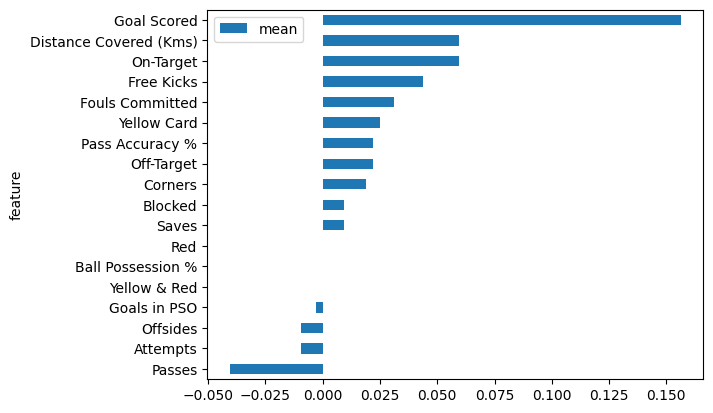

In [14]:
important_features.plot.barh(x='feature', y='mean')

So it seems that the least important features actually had a negative impact on the models performance.  

### Feature Selection
In order to produce a better model I'm going to try and use some feature selection utilities from sklearn by following [this tutorial](https://www.geeksforgeeks.org/feature-selection-using-random-forest-classifier/)

In [15]:
# Select the features which only had a positive impact
top_features = important_features.query('mean > 0')

# Create a new dataset with only the top features
train_X_selected = train_X[top_features]
test_X_selected = test_X[top_features]


In [16]:
random_forest_selected = RandomForestClassifier(n_estimators=100, random_state=0).fit(
    train_X_selected, train_y
)

# Make predictions and calculate accuracy after feature selection
y_pred_selected = random_forest_selected.predict(test_X_selected)
selected_accuracy = accuracy_score(test_y, y_pred_selected)

print(f'Accuracy before feature selection: {init_accuracy:.4f}')
print(f'Accuracy after feature selection: {selected_accuracy:.4f}')

Accuracy before feature selection: 0.6875
Accuracy after feature selection: 0.5000


In [17]:
top_features

,feature,mean,std,Weight
7,Saves,0.009375,0.039652,0.0094 ± 0.0397
8,Blocked,0.009375,0.034375,0.0094 ± 0.0344
9,Corners,0.018750,0.031869,0.0188 ± 0.0319
10,Off-Target,0.021875,0.028125,0.0219 ± 0.0281
11,Pass Accuracy %,0.021875,0.020010,0.0219 ± 0.02
12,Yellow Card,0.025000,0.023385,0.025 ± 0.0234
13,Fouls Committed,0.031250,0.019764,0.0312 ± 0.0198
14,Free Kicks,0.043750,0.050775,0.0438 ± 0.0508
15,On-Target,0.059375,0.049312,0.0594 ± 0.0493
16,Distance Covered (Kms),0.059375,0.038145,0.0594 ± 0.0381


Interesting, it seems that selecting only features which had a positive impact actually made the model worse, the more you know I guess.  
Back to the Coursera tutorial now.

### Extracting the most influential values of impactful features

In [18]:
feature_to_plot = 'Distance Covered (Kms)'

In [45]:
pdp_distance = pdp.PDPIsolate(
    model=random_forest,
    df=pd.concat([test_X, test_y], axis=1),
    model_features=test_X.columns, 
    feature=feature_to_plot,
    feature_name=feature_to_plot,
)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

In [43]:
fig,ax = pdp_distance.plot()
fig

So it seems that a player who runs between ~100-110 Kms has the largest amount of influence on the model.

In [46]:
pdp_passes = pdp.PDPIsolate(
    model=random_forest,
    df=pd.concat([test_X, test_y], axis=1),
    model_features=test_X.columns, 
    feature="Passes",
    feature_name="Passes",
)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

In [47]:
fig,ax = pdp_passes.plot()
fig